In [59]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
#Cargar los distintos datos

# Spikes
vix_data = pd.read_excel("output/vix_model_data.xlsx")
vix_data['Year'] = vix_data["Trade Date"].dt.year
spikes = vix_data[vix_data["Spike"] == "Yes"]
spikes = spikes[["Trade Date", "VIX", "Year"]]
# Cargar los datos
model_data = pd.read_excel("output/model_data_spike_5d.xlsx")
model_data['Year'] = model_data["Trade Date"].dt.year
model_data.set_index('Trade Date', inplace=True)

# Datos de 2024 y 2025
data_last_2y = model_data[(model_data.Year == 2025) | (model_data.Year == 2024)]

# Datos de 2025
data_last_y =  model_data[(model_data.Year == 2025)]

# Datos para entrenar al modelo, hasta 2023
model_data = model_data[~((model_data.Year == 2025) | (model_data.Year == 2024))]

# Eliminar columnas innecesarias
if "Futures Curve Skew" in model_data.columns:
    model_data = model_data.drop(columns=["Futures Curve Skew"])
    data_last_2y = data_last_2y.drop(columns=["Futures Curve Skew"])
    data_last_y = data_last_y.drop(columns=["Futures Curve Skew"])
data_last_2y = data_last_2y.drop(columns=["Year"])
data_last_y = data_last_y.drop(columns=["Year"])
model_data = model_data.drop(columns=["Year"])


In [61]:
# Separar features (X) y target (y)
X = model_data.drop(columns=['Spike in 5D'])
y = model_data['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividir los datos en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [62]:
# Calcular el balance de clases para ajustar `scale_pos_weight`
pos_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)  # (negatives / positives)

# Configurar el clasificador XGBoost para clasificación binaria
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=pos_weight,  # Manejo del desbalanceo
    use_label_encoder=False
)

# Hiperparámetros para el tuning
param_dist = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 1, 5],
    'reg_lambda': [1, 10, 100]
}

# Validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV para búsqueda eficiente de hiperparámetros
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1',  # Mejor métrica para desbalanceo
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Ajustar el modelo con los datos de entrenamiento
random_search.fit(X_train, y_train)

# Resultados del mejor modelo
print("Mejores hiperparámetros:", random_search.best_params_)
print("Mejor puntuación de validación cruzada:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\alber\OneDrive - CAAN Alternative Asset Management, S.A\Escritorio\vix_data\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'subsample': 1, 'reg_lambda': 1, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1}
Mejor puntuación de validación cruzada: 0.46990997186672184


In [63]:
best_model = random_search.best_estimator_

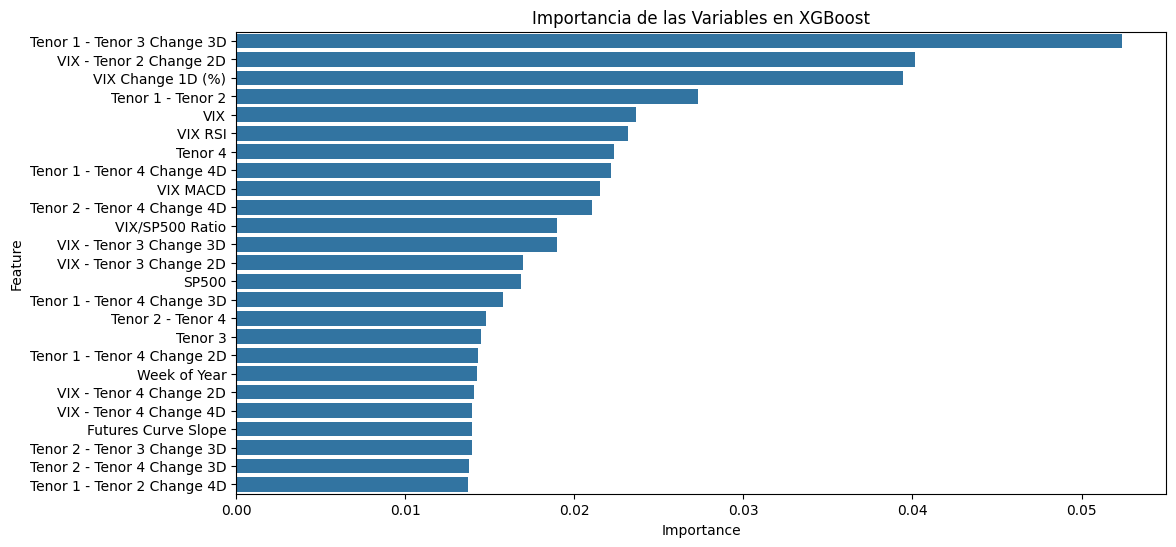

In [64]:
# Obtener importancias de las variables
feature_importance = best_model.feature_importances_

# Crear un DataFrame con los nombres de las variables y su importancia
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Ordenar de mayor a menor
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Gráfico de barras
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(25))  # Top 20
plt.title("Importancia de las Variables en XGBoost")
plt.show()

### PREDICCIONES EN TEST

In [65]:
# Predicciones en el conjunto de prueba

y_pred_encoded = best_model.predict(X_test)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)

In [66]:
# Evaluación del modelo con el set de test
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred_encoded))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_encoded))

print("\nPrecisión general:")
print(accuracy_score(y_test, y_pred_encoded))


Matriz de confusión:
[[572 126]
 [ 85  87]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84       698
           1       0.41      0.51      0.45       172

    accuracy                           0.76       870
   macro avg       0.64      0.66      0.65       870
weighted avg       0.78      0.76      0.77       870


Precisión general:
0.7574712643678161


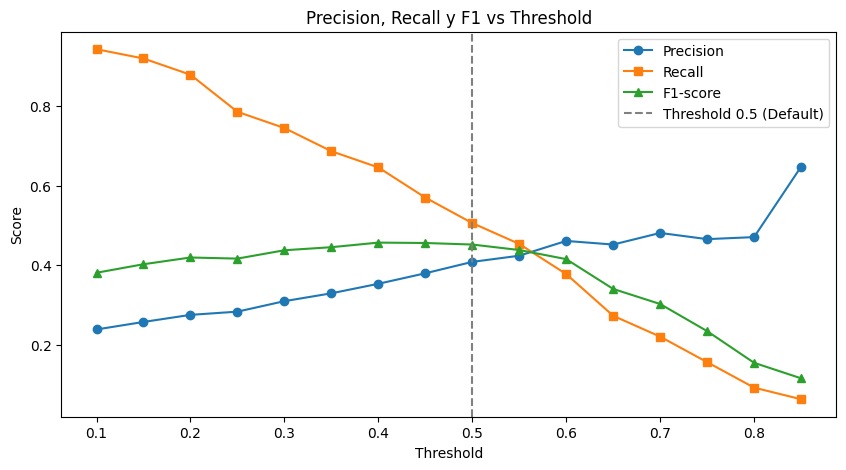

In [67]:
# Obtener probabilidades en lugar de predicciones binarias
y_pred_prob = random_search.best_estimator_.predict_proba(X_test)[:, 1]  # Probabilidad de ser "Yes"

# Probar diferentes umbrales
thresholds = np.arange(0.1, 0.9, 0.05)
precision_list = []
recall_list = []
f1_list = []

for threshold in thresholds:
    y_pred_adj = (y_pred_prob >= threshold).astype(int)
    report = classification_report(y_test, y_pred_adj, output_dict=True)
    
    precision_list.append(report["1"]["precision"])
    recall_list.append(report["1"]["recall"])
    f1_list.append(report["1"]["f1-score"])

# Graficar Precision-Recall vs. Threshold
plt.figure(figsize=(10,5))
plt.plot(thresholds, precision_list, label="Precision", marker='o')
plt.plot(thresholds, recall_list, label="Recall", marker='s')
plt.plot(thresholds, f1_list, label="F1-score", marker='^')
plt.axvline(0.5, linestyle="--", color="gray", label="Threshold 0.5 (Default)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision, Recall y F1 vs Threshold")
plt.show()

In [68]:
y_pred_prob

array([0.41401902, 0.21592316, 0.10854171, 0.01549038, 0.18598099,
       0.5188581 , 0.49965572, 0.0151306 , 0.01168863, 0.28201285,
       0.26781058, 0.8269455 , 0.373692  , 0.28287598, 0.40348694,
       0.4654244 , 0.73801595, 0.0029867 , 0.01984107, 0.39113975,
       0.8595518 , 0.10663465, 0.28508982, 0.486881  , 0.15695271,
       0.45112646, 0.13381843, 0.5493689 , 0.23151973, 0.13561924,
       0.15254758, 0.22859037, 0.42046162, 0.6795442 , 0.01482688,
       0.27210808, 0.14362948, 0.33299878, 0.14906879, 0.6703577 ,
       0.5774565 , 0.7830515 , 0.29484797, 0.03385205, 0.46391144,
       0.43336597, 0.40815812, 0.37609452, 0.06197544, 0.3990134 ,
       0.07415342, 0.06904478, 0.03571559, 0.15396571, 0.21357258,
       0.58943635, 0.01419314, 0.6174113 , 0.12697506, 0.25638932,
       0.20170307, 0.24731718, 0.58711493, 0.41485226, 0.48969132,
       0.6450607 , 0.47983593, 0.07968632, 0.0343511 , 0.2677321 ,
       0.22142664, 0.15513876, 0.25725576, 0.48468786, 0.29018

### PREDICCIONES AÑO 2025

In [83]:
# Separar features (X) y target (y)
X = data_last_y.drop(columns=['Spike in 5D'])
y = data_last_y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Generar predicciones sobre el conjunto de prueba
y_pred_encoded = best_model.predict(X)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Crear un DataFrame con las fechas de las predicciones (solo las de la prueba)
predicted_dates = X.index

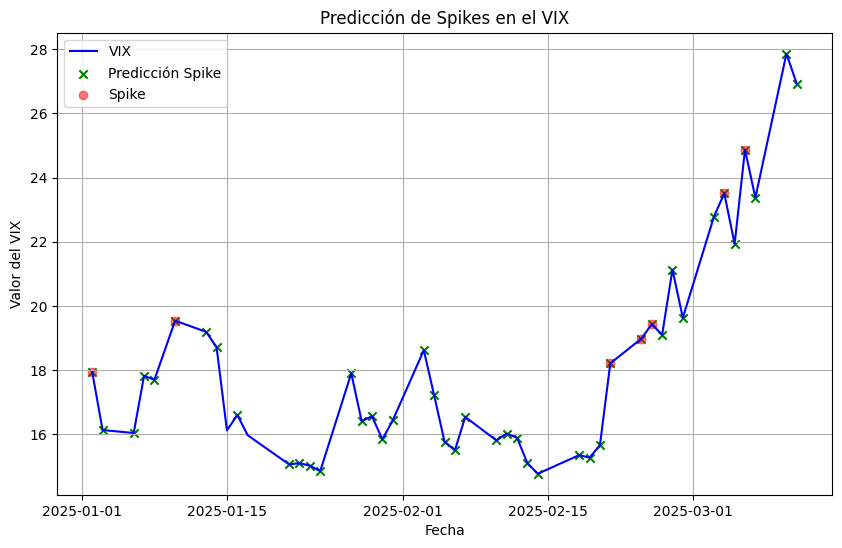

In [84]:
# Identificar los días donde el modelo predice un spike (predicción = 1)
spike_dates = predicted_dates[y_pred_encoded == 1]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar el VIX
plt.plot(data_last_y.index, data_last_y['VIX'], label='VIX', color='blue')

# Marcar los puntos verdes donde el modelo predice un spike
plt.scatter(spike_dates, data_last_y.loc[spike_dates, 'VIX'], color='green', label='Predicción Spike', marker='x')

spikes_2025 = spikes[spikes['Year'] == 2025]
# Marcar los puntos rojos donde hay un spike
plt.scatter(spikes_2025["Trade Date"],spikes_2025["VIX"], color='red', label='Spike', marker='o', alpha=0.5)

# Personalización del gráfico
plt.title('Predicción de Spikes en el VIX')
plt.xlabel('Fecha')
plt.ylabel('Valor del VIX')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [85]:
# Separar features (X) y target (y)
X = data_last_y.drop(columns=['Spike in 5D'])
y = data_last_y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Obtener las probabilidades de predicción
y_pred_prob = best_model.predict_proba(X)[:, 1]  # Probabilidad de ser "Yes"

# Definir un umbral personalizado (ajústalo según necesidad)
custom_threshold = 0.45
y_pred_adjusted = (y_pred_prob >= custom_threshold).astype(int)

# Decodificar las predicciones ajustadas
y_pred_final = label_encoder.inverse_transform(y_pred_adjusted)

# Crear un DataFrame con fechas y predicciones
predictions_df = pd.DataFrame({
    'Date': X.index,
    'Predicted Spike in 5D': y_pred_final,
    'Probability': y_pred_prob  # Opcional: Ver la probabilidad
})

# Mostrar las primeras filas
print(predictions_df.head())

        Date Predicted Spike in 5D  Probability
0 2025-01-02                   Yes     0.842166
1 2025-01-03                   Yes     0.633219
2 2025-01-06                   Yes     0.696899
3 2025-01-07                   Yes     0.841619
4 2025-01-08                   Yes     0.842825


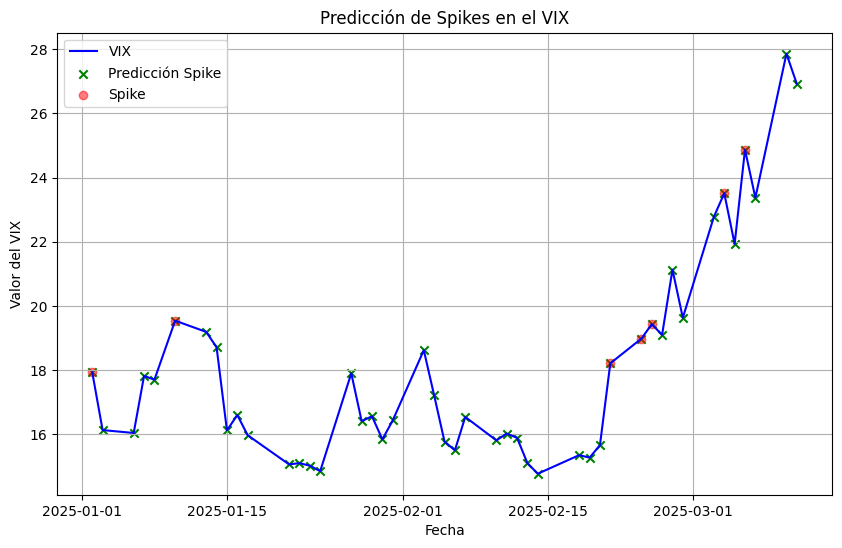

In [86]:
# Identificar los días donde el modelo predice un spike (predicción = 1)
spike_dates = predicted_dates[y_pred_adjusted == 1]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar el VIX
plt.plot(data_last_y.index, data_last_y['VIX'], label='VIX', color='blue')

# Marcar los puntos verdes donde el modelo predice un spike
plt.scatter(spike_dates, data_last_y.loc[spike_dates, 'VIX'], color='green', label='Predicción Spike', marker='x')


spikes_2025 = spikes[spikes['Year'] == 2025]
# Marcar los puntos rojos donde hay un spike
plt.scatter(spikes_2025["Trade Date"],spikes_2025["VIX"], color='red', label='Spike', marker='o', alpha=0.5)

# Personalización del gráfico
plt.title('Predicción de Spikes en el VIX')
plt.xlabel('Fecha')
plt.ylabel('Valor del VIX')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [73]:
spikes_2025

,Trade Date,VIX,Year
5224,2025-01-02,17.93,2025
5230,2025-01-10,19.54,2025
5258,2025-02-21,18.21,2025
5259,2025-02-24,18.98,2025
5260,2025-02-25,19.43,2025
5265,2025-03-04,23.51,2025
5267,2025-03-06,24.87,2025


In [74]:
spike_dates

DatetimeIndex(['2025-01-10', '2025-02-03', '2025-02-21', '2025-02-24',
               '2025-02-25', '2025-02-26', '2025-02-27', '2025-03-10'],
              dtype='datetime64[ns]', name='Trade Date', freq=None)

### PREDICCIONES AÑO 2024 y 2025

In [75]:
# Separar features (X) y target (y)
X = data_last_2y.drop(columns=['Spike in 5D'])
y = data_last_2y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Generar predicciones sobre el conjunto de prueba
y_pred_encoded = best_model.predict(X)

# Decodificar las predicciones
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Crear un DataFrame con las fechas de las predicciones (solo las de la prueba)
predicted_dates = X.index

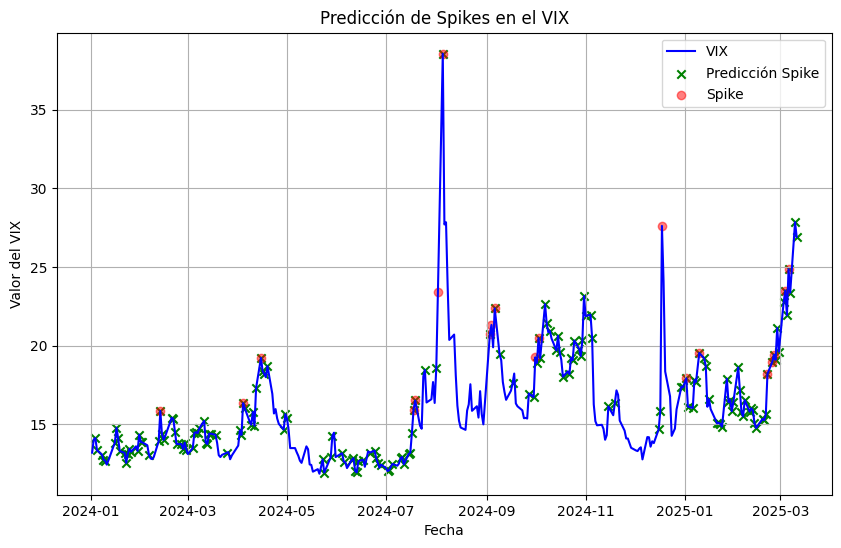

In [76]:
# Identificar los días donde el modelo predice un spike (predicción = 1)
spike_dates = predicted_dates[y_pred_encoded == 1]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar el VIX
plt.plot(data_last_2y.index, data_last_2y['VIX'], label='VIX', color='blue')

# Marcar los puntos verdes donde el modelo predice un spike
plt.scatter(spike_dates, data_last_2y.loc[spike_dates, 'VIX'], color='green', label='Predicción Spike', marker='x')


spikes_2y = spikes[(spikes['Year'] == 2025)|(spikes['Year'] == 2024)]
# Marcar los puntos rojos donde hay un spike
plt.scatter(spikes_2y["Trade Date"],spikes_2y["VIX"], color='red', label='Spike', marker='o', alpha=0.5)

# Personalización del gráfico
plt.title('Predicción de Spikes en el VIX')
plt.xlabel('Fecha')
plt.ylabel('Valor del VIX')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [79]:
# Separar features (X) y target (y)
X = data_last_2y.drop(columns=['Spike in 5D'])
y = data_last_2y['Spike in 5D']

# Codificar la variable objetivo (Yes=1, No=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Obtener las probabilidades de predicción
y_pred_prob = best_model.predict_proba(X)[:, 1]  # Probabilidad de ser "Yes"

# Definir un umbral personalizado (ajústalo según necesidad)
custom_threshold = 0.9
y_pred_adjusted = (y_pred_prob >= custom_threshold).astype(int)

# Decodificar las predicciones ajustadas
y_pred_final = label_encoder.inverse_transform(y_pred_adjusted)

# Crear un DataFrame con fechas y predicciones
predictions_df = pd.DataFrame({
    'Date': X.index,
    'Predicted Spike in 5D': y_pred_final,
    'Probability': y_pred_prob  # Opcional: Ver la probabilidad
})

# Mostrar las primeras filas
print(predictions_df.head())

        Date Predicted Spike in 5D  Probability
0 2024-01-02                    No     0.281335
1 2024-01-03                    No     0.381630
2 2024-01-04                    No     0.646095
3 2024-01-05                    No     0.559156
4 2024-01-08                    No     0.647586


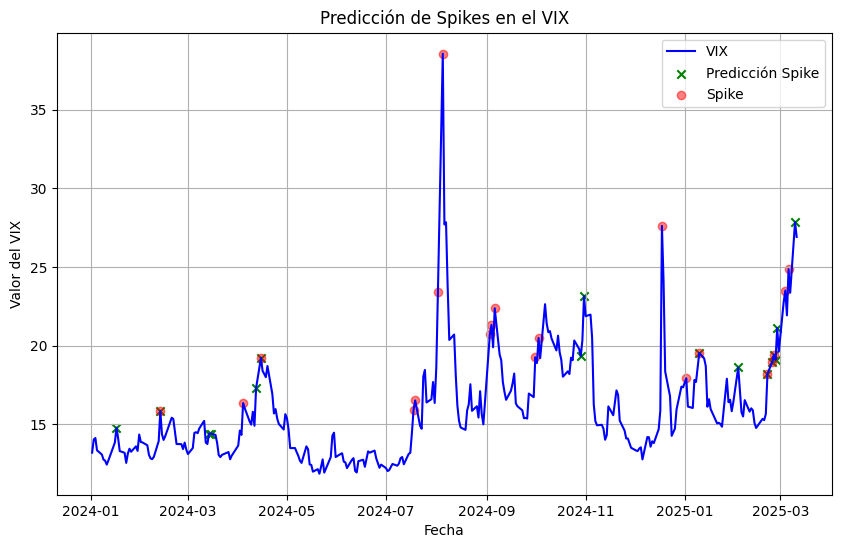

In [80]:
# Identificar los días donde el modelo predice un spike (predicción = 1)
spike_dates = predicted_dates[y_pred_adjusted == 1]

# Crear el gráfico
plt.figure(figsize=(10, 6))

# Graficar el VIX
plt.plot(data_last_2y.index, data_last_2y['VIX'], label='VIX', color='blue')

# Marcar los puntos verdes donde el modelo predice un spike
plt.scatter(spike_dates, data_last_2y.loc[spike_dates, 'VIX'], color='green', label='Predicción Spike', marker='x')

spikes_2y = spikes[(spikes['Year'] == 2025)|(spikes['Year'] == 2024)]
# Marcar los puntos rojos donde hay un spike
plt.scatter(spikes_2y["Trade Date"],spikes_2y["VIX"], color='red', label='Spike', marker='o', alpha=0.5)

# Personalización del gráfico
plt.title('Predicción de Spikes en el VIX')
plt.xlabel('Fecha')
plt.ylabel('Valor del VIX')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()